In [2]:
import os
import shutil
import random

In [3]:
def make_folder():
    try:
        os.mkdir('/tmp/Liver')
        os.mkdir('/tmp/Liver/train')
        os.mkdir('/tmp/Liver/test')
        os.mkdir('/tmp/Liver/train/f0')
        os.mkdir('/tmp/Liver/test/f0')
        os.mkdir('/tmp/Liver/train/f1')
        os.mkdir('/tmp/Liver/test/f1')
        os.mkdir('/tmp/Liver/train/f2')
        os.mkdir('/tmp/Liver/test/f2')
        os.mkdir('/tmp/Liver/train/f3')
        os.mkdir('/tmp/Liver/test/f3')
        os.mkdir('/tmp/Liver/train/f4')
        os.mkdir('/tmp/Liver/test/f4')
    except:
        pass


def train_test_split(num, f_, f_level):
    random.shuffle(f_)
    
    f_train = f_[:num]
    f_test = f_[num:num+100]
    print(f_level, "train:", len(f_train))
    print(f_level, "test:", len(f_test))
    
    folder_name = "Fibrosis_"+str(f_level)+"_masked"
    img_path = "../../../Data/Liver_mask/" + folder_name
    train_path = '/tmp/Liver/train/f'+str(f_level)
    test_path = '/tmp/Liver/test/f'+str(f_level)
    
    for img in f_train:
        shutil.copyfile(img_path+'/'+img, train_path+'/'+img)
        
    for img in f_test:
        shutil.copyfile(img_path+'/'+img, test_path+'/'+img)

In [4]:
f0 = os.listdir('../../../Data/Liver_mask/Fibrosis_0_masked')
f1 = os.listdir('../../../Data/Liver_mask/Fibrosis_1_masked')
f2 = os.listdir('../../../Data/Liver_mask/Fibrosis_2_masked')
f3 = os.listdir('../../../Data/Liver_mask/Fibrosis_3_masked')
f4 = os.listdir('../../../Data/Liver_mask/Fibrosis_4_masked')

In [5]:
make_folder()

In [6]:
train_test_split(200, f0, 0)
train_test_split(200, f1, 1)
train_test_split(200, f2, 2)
train_test_split(200, f3, 3)
train_test_split(200, f4, 4)

0 train: 200
0 test: 100
1 train: 200
1 test: 73
2 train: 200
2 test: 73
3 train: 200
3 test: 100
4 train: 200
4 test: 100


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
TRAIN_LOC = '/tmp/Liver/train'
TEST_LOC = '/tmp/Liver/test'

In [9]:
def ImageGenerator(trian_loc, test_loc):
    train_datagen = ImageDataGenerator(rescale = 1./255.,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(trian_loc,
                                                       batch_size=8,
                                                       class_mode='categorical',
                                                       target_size=(150,200),
                                                       color_mode='grayscale') # target_size = (height, width)

    test_datagen = ImageDataGenerator(rescale = 1.0/255.)
    test_generator = train_datagen.flow_from_directory(test_loc,
                                                       batch_size=16,
                                                       class_mode='categorical',
                                                       target_size=(150,200), 
                                                       color_mode='grayscale')
    
    return train_generator, test_generator

In [10]:
train_generator, test_generator = ImageGenerator(TRAIN_LOC, TEST_LOC)

Found 1000 images belonging to 5 classes.
Found 446 images belonging to 5 classes.


In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [12]:
from tensorflow.keras.layers import Layer

In [13]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__(name='')
        
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
        
    def call(self, input_tensor):
        X = self.conv1(input_tensor)
        X = self.bn1(X)
        X = self.act(X)
        
        X = self.conv2(X)
        X = self.bn2(X)
        
        X = self.add([X, input_tensor])
        X = self.act(X)
        return X
    
class ResNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        # Use the Identity blocks that you just defined
        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        
        self.flatten = tf.keras.layers.Flatten()
        self.drop = tf.keras.layers.Dropout(0.2)
        self.dense_1 = tf.keras.layers.Dense(1024, activation='sigmoid')
        self.dense_2 = tf.keras.layers.Dense(512, activation='sigmoid')
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # insert the identity blocks in the middle of the network
        x = self.id1a(x)
        x = self.id1b(x)
        x = self.global_pool(x)
        
        x = self.flatten(x)
        x = self.drop(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        
        return self.classifier(x)

In [18]:
resnet = ResNet(5)

In [19]:
resnet.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy'])

In [20]:
history = resnet.fit(train_generator,
           epochs=100,
           validation_data=test_generator)

Epoch 1/100
125/125 [==============================] - 8s 67ms/step - loss: 1.6543 - accuracy: 0.1940 - val_loss: 1.6567 - val_accuracy: 0.1637
Epoch 2/100
125/125 [==============================] - 8s 66ms/step - loss: 1.6427 - accuracy: 0.2060 - val_loss: 1.6670 - val_accuracy: 0.2242
Epoch 3/100
125/125 [==============================] - 8s 65ms/step - loss: 1.6257 - accuracy: 0.1940 - val_loss: 2.3098 - val_accuracy: 0.2242
Epoch 4/100
125/125 [==============================] - 8s 65ms/step - loss: 1.6217 - accuracy: 0.2350 - val_loss: 2.4392 - val_accuracy: 0.2242
Epoch 5/100
125/125 [==============================] - 8s 65ms/step - loss: 1.6125 - accuracy: 0.2430 - val_loss: 2.0538 - val_accuracy: 0.2242
Epoch 6/100
125/125 [==============================] - 8s 65ms/step - loss: 1.6025 - accuracy: 0.2510 - val_loss: 1.6021 - val_accuracy: 0.2242
Epoch 7/100
125/125 [==============================] - 8s 66ms/step - loss: 1.5956 - accuracy: 0.2420 - val_loss: 1.5648 - val_accuracy:

In [21]:
history2 = resnet.fit(train_generator,
           epochs=500,
           validation_data=test_generator)

Epoch 1/500
125/125 [==============================] - 8s 67ms/step - loss: 1.4196 - accuracy: 0.3530 - val_loss: 1.4134 - val_accuracy: 0.3834
Epoch 2/500
125/125 [==============================] - 8s 66ms/step - loss: 1.4299 - accuracy: 0.3690 - val_loss: 1.5154 - val_accuracy: 0.3632
Epoch 3/500
125/125 [==============================] - 8s 66ms/step - loss: 1.4246 - accuracy: 0.3460 - val_loss: 1.3774 - val_accuracy: 0.3857
Epoch 4/500
125/125 [==============================] - 8s 65ms/step - loss: 1.4223 - accuracy: 0.3680 - val_loss: 1.5095 - val_accuracy: 0.3587
Epoch 5/500
125/125 [==============================] - 8s 66ms/step - loss: 1.4144 - accuracy: 0.3610 - val_loss: 1.5261 - val_accuracy: 0.3072
Epoch 6/500
125/125 [==============================] - 8s 66ms/step - loss: 1.4251 - accuracy: 0.3570 - val_loss: 1.9440 - val_accuracy: 0.3004
Epoch 7/500
125/125 [==============================] - 8s 66ms/step - loss: 1.4167 - accuracy: 0.3710 - val_loss: 1.4319 - val_accuracy:

125/125 [==============================] - 8s 65ms/step - loss: 1.3555 - accuracy: 0.3990 - val_loss: 1.9548 - val_accuracy: 0.2892
Epoch 114/500
125/125 [==============================] - 8s 65ms/step - loss: 1.3698 - accuracy: 0.3810 - val_loss: 1.3510 - val_accuracy: 0.4013
Epoch 115/500
125/125 [==============================] - 8s 66ms/step - loss: 1.3525 - accuracy: 0.4040 - val_loss: 1.5870 - val_accuracy: 0.3206
Epoch 116/500
125/125 [==============================] - 8s 66ms/step - loss: 1.3408 - accuracy: 0.4020 - val_loss: 1.7918 - val_accuracy: 0.3161
Epoch 117/500
125/125 [==============================] - 8s 65ms/step - loss: 1.3434 - accuracy: 0.3920 - val_loss: 1.4757 - val_accuracy: 0.3341
Epoch 118/500
125/125 [==============================] - 8s 65ms/step - loss: 1.3551 - accuracy: 0.4010 - val_loss: 2.1791 - val_accuracy: 0.2601
Epoch 119/500
125/125 [==============================] - 8s 66ms/step - loss: 1.3381 - accuracy: 0.3830 - val_loss: 1.4924 - val_accuracy:

125/125 [==============================] - 8s 66ms/step - loss: 1.2991 - accuracy: 0.4190 - val_loss: 1.3107 - val_accuracy: 0.4260
Epoch 226/500
125/125 [==============================] - 8s 66ms/step - loss: 1.2709 - accuracy: 0.4390 - val_loss: 1.7390 - val_accuracy: 0.3744
Epoch 227/500
125/125 [==============================] - 8s 65ms/step - loss: 1.2969 - accuracy: 0.4340 - val_loss: 1.3587 - val_accuracy: 0.3834
Epoch 228/500
125/125 [==============================] - 8s 66ms/step - loss: 1.2854 - accuracy: 0.4350 - val_loss: 1.9504 - val_accuracy: 0.2556
Epoch 229/500
125/125 [==============================] - 8s 65ms/step - loss: 1.2893 - accuracy: 0.3990 - val_loss: 1.6286 - val_accuracy: 0.3206
Epoch 230/500
125/125 [==============================] - 8s 65ms/step - loss: 1.2836 - accuracy: 0.4420 - val_loss: 1.5039 - val_accuracy: 0.4058
Epoch 231/500
125/125 [==============================] - 8s 66ms/step - loss: 1.3045 - accuracy: 0.4220 - val_loss: 1.3657 - val_accuracy:

125/125 [==============================] - 8s 66ms/step - loss: 1.2281 - accuracy: 0.4430 - val_loss: 1.4302 - val_accuracy: 0.3789
Epoch 338/500
125/125 [==============================] - 8s 66ms/step - loss: 1.2324 - accuracy: 0.4450 - val_loss: 1.5241 - val_accuracy: 0.3812
Epoch 339/500
125/125 [==============================] - 8s 66ms/step - loss: 1.2380 - accuracy: 0.4460 - val_loss: 1.5510 - val_accuracy: 0.3879
Epoch 340/500
125/125 [==============================] - 8s 66ms/step - loss: 1.2195 - accuracy: 0.4390 - val_loss: 1.3483 - val_accuracy: 0.4238
Epoch 341/500
125/125 [==============================] - 8s 66ms/step - loss: 1.2422 - accuracy: 0.4440 - val_loss: 1.8968 - val_accuracy: 0.3004
Epoch 342/500
125/125 [==============================] - 8s 65ms/step - loss: 1.2368 - accuracy: 0.4570 - val_loss: 1.4329 - val_accuracy: 0.3969
Epoch 343/500
125/125 [==============================] - 8s 66ms/step - loss: 1.2274 - accuracy: 0.4450 - val_loss: 1.6242 - val_accuracy:

125/125 [==============================] - 8s 65ms/step - loss: 1.1850 - accuracy: 0.4800 - val_loss: 1.8266 - val_accuracy: 0.3408
Epoch 450/500
125/125 [==============================] - 8s 65ms/step - loss: 1.1695 - accuracy: 0.4860 - val_loss: 1.8736 - val_accuracy: 0.2892
Epoch 451/500
125/125 [==============================] - 8s 66ms/step - loss: 1.1844 - accuracy: 0.4850 - val_loss: 1.4086 - val_accuracy: 0.4081
Epoch 452/500
125/125 [==============================] - 8s 65ms/step - loss: 1.1854 - accuracy: 0.4710 - val_loss: 1.4130 - val_accuracy: 0.4215
Epoch 453/500
125/125 [==============================] - 8s 66ms/step - loss: 1.1852 - accuracy: 0.4490 - val_loss: 1.6830 - val_accuracy: 0.3475
Epoch 454/500
125/125 [==============================] - 8s 65ms/step - loss: 1.1877 - accuracy: 0.4690 - val_loss: 1.7854 - val_accuracy: 0.3722
Epoch 455/500
125/125 [==============================] - 8s 65ms/step - loss: 1.1827 - accuracy: 0.4840 - val_loss: 2.2227 - val_accuracy:

In [22]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

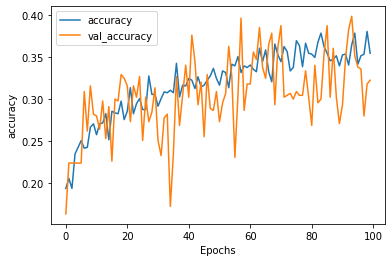

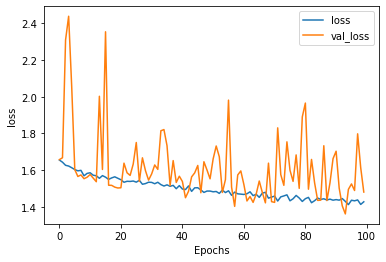

In [23]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

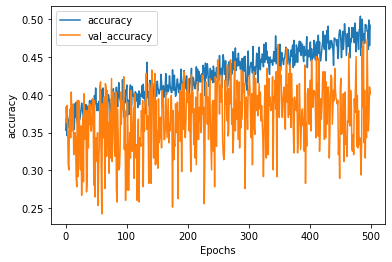

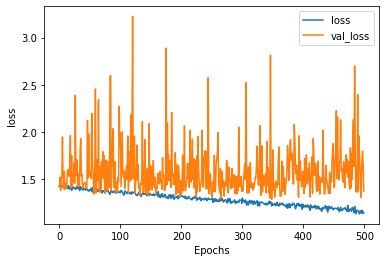

In [24]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

<Figure size 432x288 with 0 Axes>

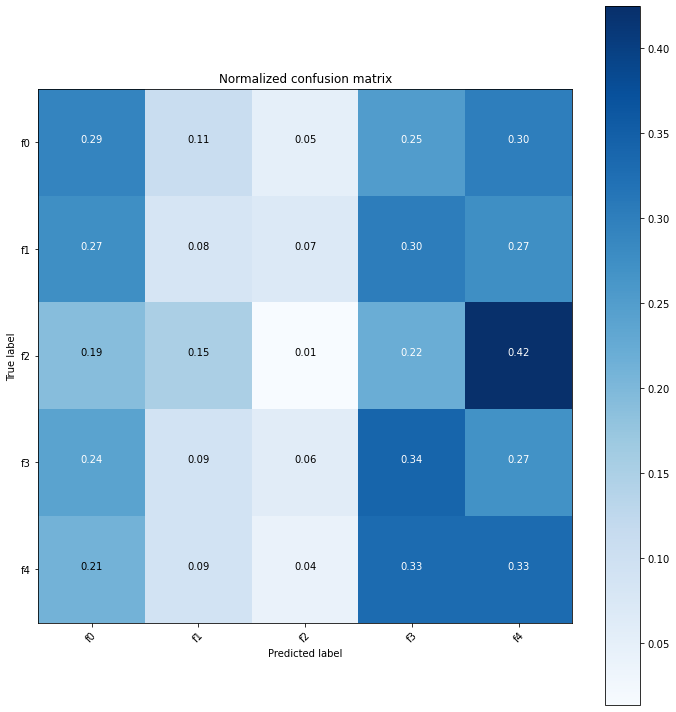

In [27]:
# heatmap
import numpy as np

predictions = resnet.predict_generator(test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [43]:
shutil.rmtree('/tmp/Liver')

In [ ]:
import os, signal
train_generator, test_generator
os.kill(os.getpid(),signal.SIGKILL)